# Word vectors from SEC filings using Gensim: Preprocessing

Run on `ml4t` environment and download sec data on `/data/sec-filings/` also download masterIndex.csv to `/data/sec-filings/filing_index.csv`

A file structure is built as follows:
* raw: `data/sec-filings/filings/`
* sections: `data/sec-filings/sections/` split each document in a pandas DF, where each row is a section
* parsed: `data/sec-filings/selected_sections/` filter and keep only targeted sections, apply text cleaning pipeline
* ngrams: `data/sec-filings/ngrams/` detect and create phrases by n-gram frequency analysis

Also spacy model should have been installed `python -m spacy download en_core_web_sm`

In this section, we will learn word and phrase vectors from annual SEC filings using gensim to illustrate the potential value of word embeddings for algorithmic trading. In the following sections, we will combine these vectors as features with price returns to train neural networks to predict equity prices from the content of security filings.

In particular, we use a dataset containing over 22,000 10-K annual reports from the period 2013-2016 that are filed by listed companies and contain both financial information and management commentary (see chapter 3 on Alternative Data). For about half of 11K filings for companies that we have stock prices to label the data for predictive modeling

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dateutil.relativedelta import relativedelta
from pathlib import Path
import numpy as np
import pandas as pd
from time import time
from collections import Counter
import logging
import spacy

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

In [3]:
np.random.seed(42)

In [4]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

### Logging Setup

In [5]:
logging.basicConfig(
        filename='preprocessing.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Data Download

The data can be downloaded from [here](https://drive.google.com/uc?id=0B4NK0q0tDtLFendmeHNsYzNVZ2M&export=download). Unzip and move into the `data` folder in the repository's root directory and rename to `sec-filings/filings`.

### Paths

Each filing is a separate text file and a master index contains filing metadata. We extract the most informative sections, namely
- Item 1 and 1A: Business and Risk Factors
- Item 7 and 7A: Management's Discussion and Disclosures about Market Risks

The notebook preprocessing shows how to parse and tokenize the text using spaCy, similar to the approach in chapter 14. We do not lemmatize the tokens to preserve nuances of word usage.

We use gensim to detect phrases. The Phrases module scores the tokens and the Phraser class transforms the text data accordingly. The notebook shows how to repeat the process to create longer phrases.

In [9]:
sec_path = Path('..', 'data', 'sec-filings')
filing_path = sec_path / 'filings'
sections_path = sec_path / 'sections'

In [7]:
if not sections_path.exists():
    sections_path.mkdir(exist_ok=True, parents=True)

## Identify Sections

files from `data/sec-filings/filings/` are read and then split in sections by `°` and writen in `sections_path=\data\sec-filings\sections`

In [ ]:
for i, filing in enumerate(filing_path.glob('*.txt'), 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    filing_id = int(filing.stem)
    items = {}
    for section in filing.read_text().lower().split('°'):
        if section.startswith('item '):
            if len(section.split()) > 1:
                item = section.split()[1].replace('.', '').replace(':', '').replace(',', '')
                text = ' '.join([t for t in section.split()[2:]])
                if items.get(item) is None or len(items.get(item)) < len(text):
                    items[item] = text

    txt = pd.Series(items).reset_index()
    txt.columns = ['item', 'text']
    txt.to_csv(sections_path / (filing.stem + '.csv'), index=False)

## Parse Sections

Select the following sections:

In [8]:
sections = ['1', '1a', '7', '7a']

In [9]:
clean_path = sec_path / 'selected_sections'
if not clean_path.exists():
    clean_path.mkdir(exist_ok=True)

In [11]:
#%%bash
#python -m spacy download en_core_web_sm

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.max_length = 6000000

In [ ]:
# For each section_doc, create a pandas DF where each row is a sentence
# item, sentence, text
vocab = Counter()
t = total_tokens = 0
stats = []

start = time()
to_do = len(list(sections_path.glob('*.csv')))
done = len(list(clean_path.glob('*.csv'))) + 1
for text_file in sections_path.glob('*.csv'):
    file_id = int(text_file.stem)
    clean_file = clean_path / f'{file_id}.csv'
    if clean_file.exists():
        continue
    items = pd.read_csv(text_file).dropna()
    items.item = items.item.astype(str)
    items = items[items.item.isin(sections)]
    if done % 100 == 0:
        duration = time() - start
        to_go = (to_do - done) * duration / done
        print(f'{done:>5}\t{format_time(duration)}\t{total_tokens / duration:,.0f}\t{format_time(to_go)}')
    
    clean_doc = []
    for _, (item, text) in items.iterrows():
        doc = nlp(text)
        for s, sentence in enumerate(doc.sents):
            clean_sentence = []
            if sentence is not None:
                for t, token in enumerate(sentence, 1):
                    if not any([token.is_stop,
                                token.is_digit,
                                not token.is_alpha,
                                token.is_punct,
                                token.is_space,
                                token.lemma_ == '-PRON-',
                                token.pos_ in ['PUNCT', 'SYM', 'X']]):
                        clean_sentence.append(token.text.lower())
                total_tokens += t
                if len(clean_sentence) > 0:
                    clean_doc.append([item, s, ' '.join(clean_sentence)])
    (pd.DataFrame(clean_doc,
                  columns=['item', 'sentence', 'text'])
     .dropna()
     .to_csv(clean_file, index=False))
    done += 1

## Create ngrams

In [19]:
ngram_path = sec_path / 'ngrams'
stats_path = sec_path / 'corpus_stats'
for path in [ngram_path, stats_path]:
    if not path.exists():
        path.mkdir(parents=True)

In [20]:
unigrams = ngram_path / 'ngrams_1.txt'

In [14]:
clean_path

PosixPath('../data/sec-filings/selected_sections')

In [16]:
def create_unigrams(min_length=3):
    texts = []
    sentence_counter = Counter()
    vocab = Counter()
    for i, f in enumerate(clean_path.glob('*.csv')):
        if i % 1000 == 0:
            print(i, end=' ', flush=True)
        df = pd.read_csv(f)
        df.item = df.item.astype(str)
        df = df[df.item.isin(sections)]
        sentence_counter.update(df.groupby('item').size().to_dict())
        for sentence in df.text.dropna().str.split().tolist():
            if len(sentence) >= min_length:
                vocab.update(sentence)
                texts.append(' '.join(sentence))
    
    (pd.DataFrame(sentence_counter.most_common(), 
                  columns=['item', 'sentences'])
     .to_csv(stats_path / 'selected_sentences.csv', index=False))
    (pd.DataFrame(vocab.most_common(), columns=['token', 'n'])
     .to_csv(stats_path / 'sections_vocab.csv', index=False))
    
    unigrams.write_text('\n'.join(texts))
    return [l.split() for l in texts]

In [ ]:
start = time()
if not unigrams.exists():
    texts = create_unigrams()
else:
    texts = [l.split() for l in unigrams.open()]
print('\nReading: ', format_time(time() - start))

In [15]:
def create_ngrams(max_length=3):
    """Using gensim to create ngrams"""
    # example in 03_financial_news_preprocessing

    n_grams = pd.DataFrame()
    start = time()
    for n in range(2, max_length + 1):
        print(n, end=' ', flush=True)

        sentences = LineSentence(ngram_path / f'ngrams_{n - 1}.txt')
        phrases = Phrases(sentences=sentences,
                          min_count=25,  # ignore terms with a lower count
                          threshold=0.5,  # accept phrases with higher score
                          max_vocab_size=40000000,  # prune of less common words to limit memory use
                          delimiter=b'_',  # how to join ngram tokens
                          progress_per=50000,  # log progress every
                          scoring='npmi')

        s = pd.DataFrame([[k.decode('utf-8'), v] for k, v in phrases.export_phrases(sentences)], 
                         columns=['phrase', 'score']).assign(length=n)

        n_grams = pd.concat([n_grams, s])
        grams = Phraser(phrases)
        sentences = grams[sentences]
        (ngram_path / f'ngrams_{n}.txt').write_text('\n'.join([' '.join(s) for s in sentences]))

    n_grams = n_grams.sort_values('score', ascending=False)
    n_grams.phrase = n_grams.phrase.str.replace('_', ' ')
    n_grams['ngram'] = n_grams.phrase.str.replace(' ', '_')

    n_grams.to_parquet(sec_path / 'ngrams.parquet')

    print('\n\tDuration: ', format_time(time() - start))
    print('\tngrams: {:,d}\n'.format(len(n_grams)))
    print(n_grams.groupby('length').size())

In [16]:
create_ngrams()

2 3 
	Duration:  02:57:18
	ngrams: 38,653,849

length
2    27747716
3    10906133
dtype: int64


## Inspect Corpus

In [15]:
percentiles=np.arange(.1, 1, .1).round(2)

In [18]:
nsents, ntokens = Counter(), Counter()
for f in clean_path.glob('*.csv'):
    df = pd.read_csv(f)
    nsents.update({str(k): v for k, v in df.item.value_counts().to_dict().items()})
    df['ntokens'] = df.text.str.split().str.len()
    ntokens.update({str(k): v for k, v in df.groupby('item').ntokens.sum().to_dict().items()})

In [19]:
ntokens = pd.DataFrame(ntokens.most_common(), columns=['Item', '# Tokens'])
nsents = pd.DataFrame(nsents.most_common(), columns=['Item', '# Sentences'])

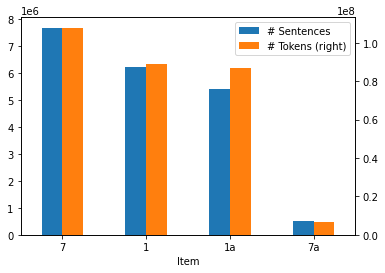

In [20]:
nsents.set_index('Item').join(ntokens.set_index('Item')).plot.bar(secondary_y='# Tokens', rot=0);

In [11]:
ngrams = pd.read_parquet(sec_path / 'ngrams.parquet')

In [12]:
ngrams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38653849 entries, 4451036 to 2596995
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   phrase  object 
 1   score   float64
 2   length  int64  
 3   ngram   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.4+ GB


In [13]:
ngrams.head()

,phrase,score,length,ngram
4451036,xyrem sodium oxybate,1.0,3,xyrem_sodium_oxybate
4298818,atalanta sosnoff,1.0,2,atalanta_sosnoff
7327539,mountaineer presque isle downs,1.0,3,mountaineer_presque_isle_downs
7327521,mountaineer presque isle downs,1.0,3,mountaineer_presque_isle_downs
7327515,mountaineer presque isle downs,1.0,3,mountaineer_presque_isle_downs


In [16]:
ngrams.score.describe(percentiles=percentiles)

count    3.865385e+07
mean     6.589699e-01
std      1.267425e-01
min      5.000015e-01
10%      5.169397e-01
20%      5.364318e-01
30%      5.635906e-01
40%      5.926600e-01
50%      6.227109e-01
60%      6.752993e-01
70%      7.198722e-01
80%      7.832971e-01
90%      8.394894e-01
max      1.000000e+00
Name: score, dtype: float64

In [17]:
ngrams[ngrams.score>.7].sort_values(['length', 'score']).head(10)

,phrase,score,length,ngram
14869344,adobe photoshop,0.700028,2,adobe_photoshop
7151180,adobe photoshop,0.700028,2,adobe_photoshop
18431276,adobe photoshop,0.700028,2,adobe_photoshop
26633038,adobe photoshop,0.700028,2,adobe_photoshop
18430958,adobe photoshop,0.700028,2,adobe_photoshop
14869262,adobe photoshop,0.700028,2,adobe_photoshop
18431063,adobe photoshop,0.700028,2,adobe_photoshop
18431296,adobe photoshop,0.700028,2,adobe_photoshop
14869320,adobe photoshop,0.700028,2,adobe_photoshop
24351586,adobe photoshop,0.700028,2,adobe_photoshop


In [21]:
vocab = pd.read_csv(stats_path / 'sections_vocab.csv').dropna()

In [22]:
vocab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200867 entries, 0 to 200868
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   200867 non-null  object
 1   n       200867 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [23]:
vocab.n.describe(percentiles).astype(int)

count     200867
mean        1439
std        22312
min            1
10%            1
20%            2
30%            3
40%            4
50%            7
60%           12
70%           24
80%           61
90%          260
max      2574572
Name: n, dtype: int64

In [24]:
tokens = Counter()
for l in (ngram_path / 'ngrams_2.txt').open():
    tokens.update(l.split())

In [25]:
tokens = pd.DataFrame(tokens.most_common(),
                     columns=['token', 'count'])

In [26]:
tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230112 entries, 0 to 230111
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   230112 non-null  object
 1   count   230112 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [27]:
tokens.head()

,token,count
0,million,2340187
1,business,1696732
2,december,1512367
3,company,1490617
4,products,1367413


In [28]:
tokens.loc[tokens.token.str.contains('_'), 'count'].describe(percentiles).astype(int)

count     29951
mean        926
std        9611
min           1
10%          26
20%          31
30%          37
40%          46
50%          61
60%          85
70%         131
80%         237
90%         666
max      593859
Name: count, dtype: int64

In [29]:
tokens[tokens.token.str.contains('_')].head(20).to_csv(sec_path / 'ngram_examples.csv', index=False)

In [30]:
tokens[tokens.token.str.contains('_')].head(20)

,token,count
46,year_ended,593859
64,results_operations,492047
71,table_contents,436034
78,company_s,412971
85,financial_condition,396164
86,common_stock,387629
107,fair_value,341108
152,united_states,276401
158,cash_flows,266725
168,financial_statements,255115


## Get returns

In [6]:
DATA_FOLDER = Path('..', 'data')

In [7]:
with pd.HDFStore(DATA_FOLDER / 'assets.h5') as store:
    prices = store['quandl/wiki/prices'].adj_close

In [10]:
sec = pd.read_csv(sec_path / 'filing_index.csv').rename(columns=str.lower)
sec.date_filed = pd.to_datetime(sec.date_filed)

In [11]:
sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22631 entries, 0 to 22630
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cik           22631 non-null  int64         
 1   company_name  22631 non-null  object        
 2   form_type     22631 non-null  object        
 3   date_filed    22631 non-null  datetime64[ns]
 4   edgar_link    22631 non-null  object        
 5   quarter       22631 non-null  int64         
 6   ticker        22631 non-null  object        
 7   sic           22461 non-null  object        
 8   exchange      20619 non-null  object        
 9   hits          22555 non-null  object        
 10  year          22631 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.9+ MB


In [12]:
pd.concat([sec.head(3), sec.tail(3)], axis=0)

,cik,company_name,form_type,date_filed,edgar_link,quarter,ticker,sic,exchange,hits,year
0,1000180,SANDISK CORP,10-K,2013-02-19,edgar/data/1000180/0001000180-13-000009.txt,1,SNDK,3572,NASDAQ,3,2013
1,1000209,MEDALLION FINANCIAL CORP,10-K,2013-03-13,edgar/data/1000209/0001193125-13-103504.txt,1,TAXI,6199,NASDAQ,0,2013
2,1000228,HENRY SCHEIN INC,10-K,2013-02-13,edgar/data/1000228/0001000228-13-000010.txt,1,HSIC,5047,NASDAQ,3,2013
22628,936395,CIENA CORP,10-K,2016-12-21,edgar/data/936395/0000936395-16-000128.txt,4,CIEN,3661,NASDAQ,0,2016
22629,936528,WASHINGTON FEDERAL INC,10-K,2016-11-21,edgar/data/936528/0000936528-16-000090.txt,4,WAFD,6035,NASDAQ,1,2016
22630,96699,TECHNICAL COMMUNICATIONS CORP,10-K,2016-12-23,edgar/data/96699/0001144204-16-141277.txt,4,TCCO,3663,NASDAQ,1,2016


In [13]:
idx = pd.IndexSlice

In [15]:
first = sec.date_filed.min() + relativedelta(months=-1)
last = sec.date_filed.max() + relativedelta(months=1)
prices = (prices
          .loc[idx[first:last, :]]
          .unstack().resample('D')
          .ffill()
          .dropna(how='all', axis=1)
          .filter(sec.ticker.unique()))

In [17]:
prices.shape # daily prices on 3k stocks, from 2013 to 2017, in order to merge with sec corpus

(1520, 2992)

In [16]:
pd.concat([prices.head(3), prices.tail(3)], axis=0)

ticker,SNDK,TAXI,HSIC,SWM,NVAX,WAT,NSP,DISH,SGMO,LXK,...,CFG,TNET,SPWH,LPG,WRK,HPE,BXLT,CPGX,PYPL,SQBG
date,,,,,,,,,,,,,,,,,,,,,
2012-12-03,38.255696,9.362168,40.33500,30.984582,1.83,84.14,25.595009,35.608935,5.46,20.912406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50
2012-12-04,38.999713,9.314116,40.30500,31.100723,1.87,84.43,25.845205,36.212477,5.41,21.138017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50
2012-12-05,38.516992,9.258055,40.01955,31.075836,1.82,84.15,26.128760,35.170881,5.42,21.059921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50
2017-01-28,NaN,NaN,79.82500,43.568097,1.33,144.38,70.966668,59.280000,3.55,NaN,...,36.349433,25.50,7.89,11.20,52.362952,22.287699,NaN,NaN,40.27,4.61
2017-01-29,NaN,NaN,79.82500,43.568097,1.33,144.38,70.966668,59.280000,3.55,NaN,...,36.349433,25.50,7.89,11.20,52.362952,22.287699,NaN,NaN,40.27,4.61
2017-01-30,NaN,NaN,79.16000,42.132102,1.28,140.95,70.273827,59.340000,3.55,NaN,...,35.897399,24.97,7.51,12.38,52.217257,21.892352,NaN,NaN,39.86,4.61


In [19]:
sec.ticker.drop_duplicates().shape  #number of stocks in sec corpus (over 22k docs)

(6630,)

In [23]:
import datetime as dt
dt.datetime(2019, 1, 1) + relativedelta(months=1)

datetime.datetime(2019, 2, 1, 0, 0)

In [24]:
# compute 1 months (30 days) returns, on `19_recurrent_neural_nets/07_sec_filings_return_prediction.ipynb` 5d return prediction is performed using RNNs
sec = sec.loc[sec.ticker.isin(prices.columns), ['ticker', 'date_filed']]

price_data = []
for ticker, date in sec.values.tolist():
    target = date + relativedelta(months=1)
    s = prices.loc[date: target, ticker]  # from current date to target date
    price_data.append(s.iloc[-1] / s.iloc[0] - 1)  # pct_change difference between last and first

df = pd.DataFrame(price_data,
                  columns=['returns'],
                  index=sec.index)

In [25]:
df.returns.describe()       

count    11101.000000
mean         0.022839
std          0.126137
min         -0.555556
25%         -0.032213
50%          0.017349
75%          0.067330
max          1.928826
Name: returns, dtype: float64

In [28]:
date, target

(Timestamp('2016-11-21 00:00:00'), Timestamp('2016-12-21 00:00:00'))

In [29]:
sec['returns'] = price_data
sec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11375 entries, 0 to 22629
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ticker      11375 non-null  object        
 1   date_filed  11375 non-null  datetime64[ns]
 2   returns     11101 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 355.5+ KB


In [30]:
sec.dropna().to_csv(sec_path / 'sec_returns.csv', index=False)